In [1]:
import sys

import torch_geometric.transforms

sys.path.append('../')

import random
from incidence_graph import IncidenceGraph
import multignn
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch_geometric.datasets as datasets

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'Available memory: {torch.cuda.get_device_properties(device).total_memory / 1024 ** 3 - torch.cuda.memory_allocated(device) / 1024 ** 3:.2f} GB')

Using device: cuda
Available memory: 11.90 GB


In [2]:
DATA = datasets.Planetoid(name='Pubmed', root='pubmed_data')[0]
G = IncidenceGraph()
for edge in DATA.edge_index.T:
    G.put_simplex((edge[0].item(), edge[1].item()))
X = DATA.x.to(device=device)
Y = DATA.y
CATS = max(Y) + 1
V = G.size(0)

print(f'Graph shape: {G.shape()}')
print(f'Categories: {CATS}')

Graph shape: [19717, 44324]
Categories: 3


In [10]:
MAX_DIST = 5
Ds = [i for i in G.degree_lists(neighbor_dists=range(MAX_DIST + 1), rel_dims=[], node_list=range(V), pow=-1, add=1)[0].values()]
edge_list = torch.as_tensor([list(range(V)), list(range(V))])
As = G.sparse_matrices(neighbor_dists=range(MAX_DIST+1), rel_dims=[], dims=[0])
for i in range(1, MAX_DIST+1):
    diag = torch.sparse_coo_tensor(edge_list, Ds[i], size=(V, V)).coalesce()
    As[i] = torch.sparse.mm(diag, As[i] + As[0]).to(device=device)

In [19]:
# run to change GPU
for i in range(1, MAX_DIST+1):
    As[i] = As[i].to(device=device)
X = X.to(device=device)

In [4]:
def train(SEED, A_SIZE, D, EPOCHS, LOGGING, LAYERS=1):
    random.seed(SEED)
    torch.random.manual_seed(SEED)

    A = As[1:A_SIZE+1]
    layers = []
    for i in range(LAYERS):
        in_shape = X.shape[1] if i == 0 else D
        output_func = nn.Sequential(nn.Linear(D, CATS), nn.LogSoftmax(dim=1)) if i == LAYERS - 1 else None
        layers.append(multignn.MultiGraphLayer(vertex_agg_func=multignn.sparse_vertex_agg,
                                               update_func= multignn.LinearMessageUpdate(in_shape, in_shape, D, activation_func=nn.ReLU(), use_bias=True),
                                               output_func=output_func))
    model = multignn.PartialForwardNN(*layers).to(device=device)
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.NLLLoss()
    #sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

    tr_losses = []
    val_losses = []

    it = range(EPOCHS)
    if LOGGING == 0:
        it = tqdm(it, desc='Training')
    elif LOGGING == 1:
        print('Epoch #: Train Loss, Validation Loss, Validation Accuracy')

    for epoch in it:
        opt.zero_grad()
        output = model.forward(X, A).to(device='cpu')
        loss = loss_func(output[DATA.train_mask], Y[DATA.train_mask])
        loss.backward()
        opt.step()
        tr_losses.append(loss.item())

        with torch.no_grad():
            output = model.forward(X, A)[DATA.val_mask].to(device='cpu')
            val_loss = loss_func(output, Y[DATA.val_mask])
            val_losses.append(val_loss.item())
            pred = torch.argmax(output, dim=1)
            val_acc = (pred == Y[DATA.val_mask]).sum().item() / len(pred)
            #sched.step(val_loss)

        if LOGGING == 1:
            print(f'Epoch {epoch + 1:4}\t{loss.item():.8f}\t{val_loss.item():.8f}\t{val_acc:.3f}')

    if LOGGING == 0:
        it.close()

    return model, tr_losses, val_losses

In [5]:
def plot(tr_losses, val_losses, start=0, filename=None):
    xs = list(range(start, len(tr_losses)))
    plt.rcParams['figure.figsize'] = (9.0, 6.0)
    plt.plot(xs, tr_losses[start:], label='training loss')
    plt.plot(xs, val_losses[start:], label='validation loss')
    #plt.yscale('log', base=16)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss values from epochs {start + 1} to {len(tr_losses)}')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [6]:
def test(model, A_SIZE):
    A = As[1:A_SIZE+1]
    model.eval()
    output = model.forward(X, A).to(device='cpu')
    pred = output[DATA.test_mask].argmax(dim=1)
    acc = (pred == Y[DATA.test_mask]).sum().item() / len(pred)
    return acc

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [01:43<00:00,  2.29s/it]


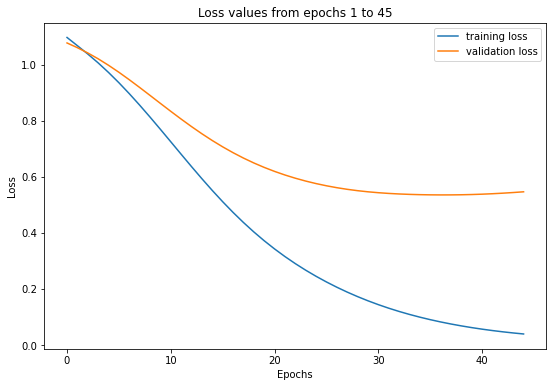

Test accuracy: 78.70


In [12]:
# 1024- 50 epochs 45
# 512 - 65 epochs 55
# 256 - 75 epochs
A_SIZE = 5
model, tr_losses, val_losses = train(-1, A_SIZE, 1024, 45, 0)
plot(tr_losses, val_losses)
print(f'Test accuracy: {test(model, A_SIZE) * 100:.2f}')

In [13]:
results = []
for seed in tqdm(range(100)):
    model, _, _ = train(seed, 5, 1024, 45, -1)
    results.append(test(model, 5))
print(f'MEAN: {torch.mean(torch.tensor(results)).item() * 100:.2f}')
print(f'MED: {torch.median(torch.tensor(results)).item() * 100:.2f}')
print(f'STDDEV: {torch.std(torch.tensor(results)).item() * 100:.2f}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [3:04:52<00:00, 110.93s/it]

MEAN: 78.72
MED: 78.70
STDDEV: 0.16


In [ ]:
"""
best: ASIZE=5 epochs=45 D=1024 78.72 0.16, 78.70

TODO: single-layer vs multi-layer?
TODO: performance vs. diff number of adj distances?
"""